In [24]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mpl
import matplotlib.pylab as plt
from datetime import datetime
import statsmodels.api as sm
import scipy
import yfinance as yf
from pykalman import KalmanFilter
from math import sqrt

### Backtesting

In [25]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mpl
import matplotlib.pylab as plt
from datetime import datetime
import statsmodels.api as sm
import scipy
from math import sqrt




def backtest(df,s1, s2):
    #############################################################
    # INPUT:
    # DataFrame of prices
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two
    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: Sharpe ratio
    # CAGR: Compound Annual Growth Rate
    x = df[s1]
    y = df[s2]
    # run regression (including Kalman Filter) to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index)
    
    #Use smoothed out series to regress hedge ratio
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    df1['hr'] = state_means[:,0]
    df1['spread'] = df1.y - (df1.x * df1.hr)
    
    # calculate half life
    halflife = half_life(df1['spread'])
    
    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    

    # Trading logic
    entryZscore = 1
    exitZscore = 0
    
    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad') 
    
    #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    
    #Examine, why divide with total value of stocks?
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    #
    
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1
    ##############################################################
    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0
    ##############################################################
    start_val = 1
    end_val = df1['cum rets'].iat[-1]
    
    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name
    days = (end_date - start_date).days
    
    CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)
    df1[s1+ " "+s2] = df1['cum rets']
    
    return df1[s1+" "+s2], sharpe, CAGR

In [26]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mpl
import matplotlib.pylab as plt
from datetime import datetime
import statsmodels.api as sm
import scipy
import yfinance as yf
from pykalman import KalmanFilter
from math import sqrt

def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
    
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0], #x_0
    initial_state_covariance=np.ones((2, 2)), #P_0
    transition_matrices=np.eye(2), #A_k
    observation_matrices=obs_mat, #H_k
    observation_covariance=2, # R_k
    transition_covariance=trans_cov) # Q_k
    
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

#NOTE CRITICAL LEVEL HAS BEEN SET TO 5% FOR COINTEGRATION TEST

def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] # the length of dateframe
    pvalue_matrix = np.ones((n, n)) # initialize the matrix of p
    keys = dataframe.columns # get the column names
    pairs = [] # initilize the list for cointegration
    for i in range(n):
        for j in range(i+1, n): # for j bigger than i
            stock1 = dataframe[keys[i]] # obtain the price of "stock1"
            stock2 = dataframe[keys[j]]# obtain the price of "stock2"
            result = sm.tsa.stattools.coint(stock1, stock2) # get conintegration
            pvalue = result[1] # get the pvalue
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pvalue)) # record the contract with that p-value
    return pvalue_matrix, pairs

### Drawdown function

In [27]:
def drawdown_metric(equity_curve):
   drawdown = equity_curve/equity_curve.cummax() - 1
   max_drawdown = drawdown.min()
   
   drawdown_period = []
   
   count = 0
   for t in abs(drawdown.values):
      if t == 0:
         drawdown_period.append(count)
         count = 0

      count += 1
   
   max_drawdown_period = max(drawdown_period)
      
   return drawdown, max_drawdown, max_drawdown_period

[*********************100%***********************]  4 of 4 completed


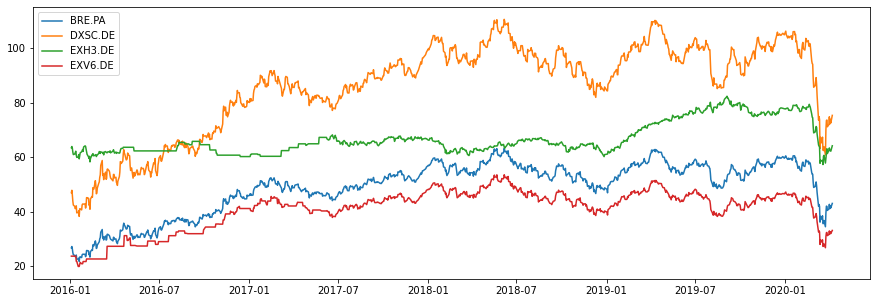

In [28]:
start_date = "2016-01-01"
end_date = "2020-12-01"

# Get data for stocks
#tickers = 'VNET AKAM BIDU BCOR WIFI JRJC CCIH CCOI ENV FB GDDY IAC IPAS JCOM LLNW MOM NTES EGOV SIFY SINA TWTR WEB XNET YNDX'
tickers = 'EXV6.DE BRE.PA DXSC.DE EXH3.DE'
data = yf.download(tickers, start=start_date, end=end_date)

#Only take the closing price.
#data = data["Close"]#.fillna(method="ffill")

data = data['Close'].dropna()
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(data)
plt.legend(data.columns)
plt.show()

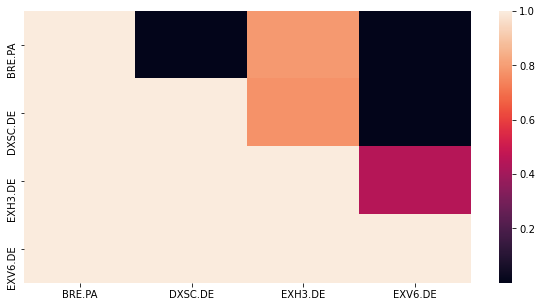

In [29]:
#Find Cointegrated pair from training data.
split = int(len(data) * 0.4)

training_data = data[:split]

pval, pairs = find_cointegrated_pairs(training_data)
pval_matrix = pd.DataFrame(pval)

fig, ax = plt.subplots(figsize=(10
                                ,5))
sb.heatmap(pval_matrix, xticklabels=data.columns, yticklabels=data.columns, ax=ax)

In [30]:
for pair in pairs:
    print("Stock {} and stock {} has a co-integration score of {}".format(pair[0],pair[1],round(pair[2],6)))

pval_matrix

Stock BRE.PA and stock DXSC.DE has a co-integration score of 0.000119
Stock BRE.PA and stock EXV6.DE has a co-integration score of 0.0
Stock DXSC.DE and stock EXV6.DE has a co-integration score of 0.0


,0,1,2,3
0,1.0,0.000119,0.792790,1.736221e-07
1,1.0,1.000000,0.776859,1.164350e-07
2,1.0,1.000000,1.000000,4.453705e-01
3,1.0,1.000000,1.000000,1.000000e+00


/Users/wojtasratusznik/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
<ipython-input-25-d9b6f85c0914>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1['num units long'][0] = 0
<ipython-input-25-d9b6f85c0914>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1['num units short'][0] = 0


The pair BRE.PA and DXSC.DE produced a Sharpe Ratio of 0.0 and a CAGR of 0.0


/Users/wojtasratusznik/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
<ipython-input-25-d9b6f85c0914>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1['num units long'][0] = 0
<ipython-input-25-d9b6f85c0914>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1['num units short'][0] = 0


The pair BRE.PA and EXV6.DE produced a Sharpe Ratio of 0.68 and a CAGR of 0.0766


/Users/wojtasratusznik/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
<ipython-input-25-d9b6f85c0914>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1['num units long'][0] = 0
<ipython-input-25-d9b6f85c0914>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1['num units short'][0] = 0


The pair DXSC.DE and EXV6.DE produced a Sharpe Ratio of 1.25 and a CAGR of 0.1314


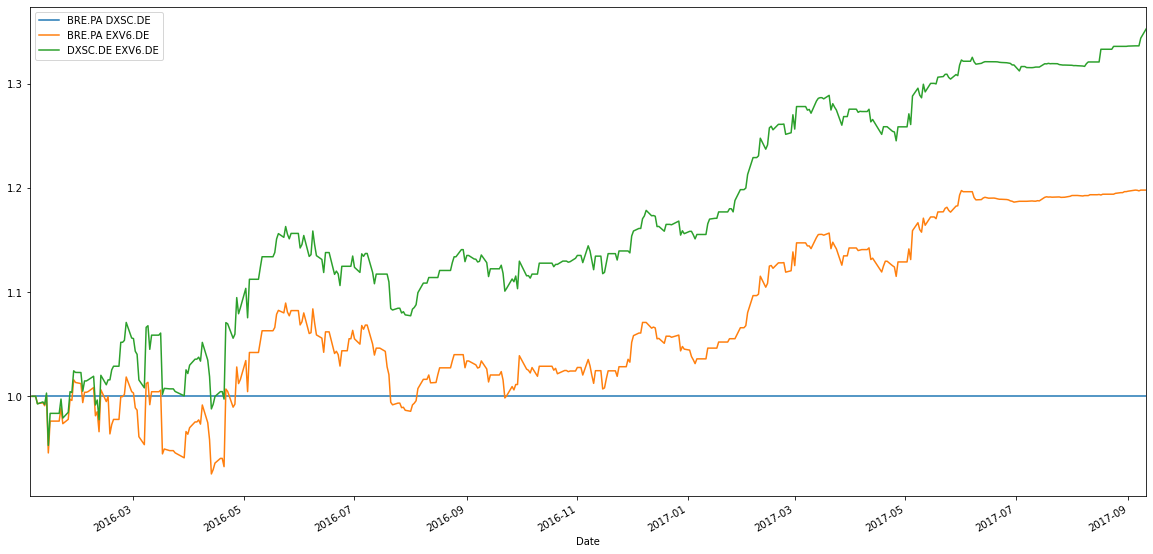

In [31]:
results = []
for pair in pairs:
    rets, sharpe,  CAGR = backtest(data[:split],pair[0],pair[1])
    results.append(rets)
    print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],round(sharpe,2),round(CAGR,4)))
    rets.plot(figsize=(20,10),legend=True)

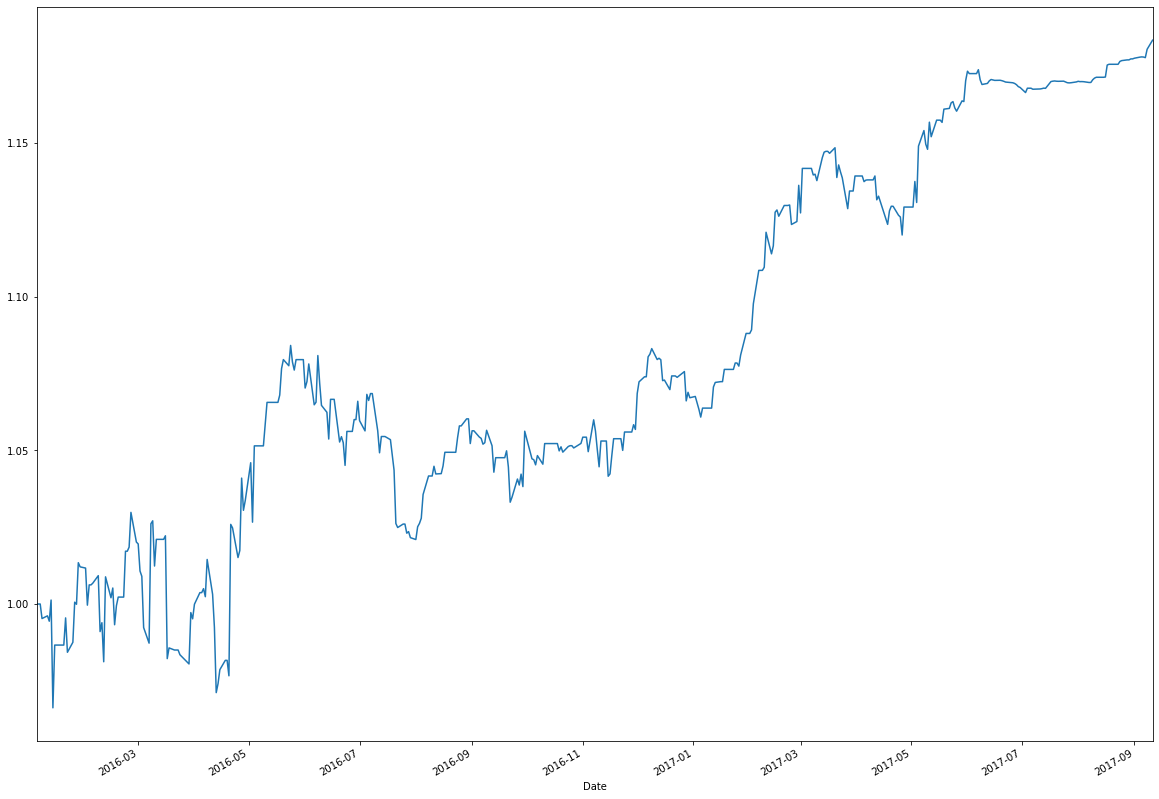

In [32]:
#Create weights based on sharpe or some metric
results_df = pd.concat(results,axis=1).dropna()

results_df = results_df/len(results_df.columns)

#sum up the equally weighted equity curves to get our final equity curve
final_res = results_df.sum(axis=1)

drawdown, maxdd, maxdd_period = drawdown_metric(final_res)

#plot the chart of our final equity curve
final_res.plot(figsize=(20,15))

### Drawdown plot

(-0.0582331929282045, 177)

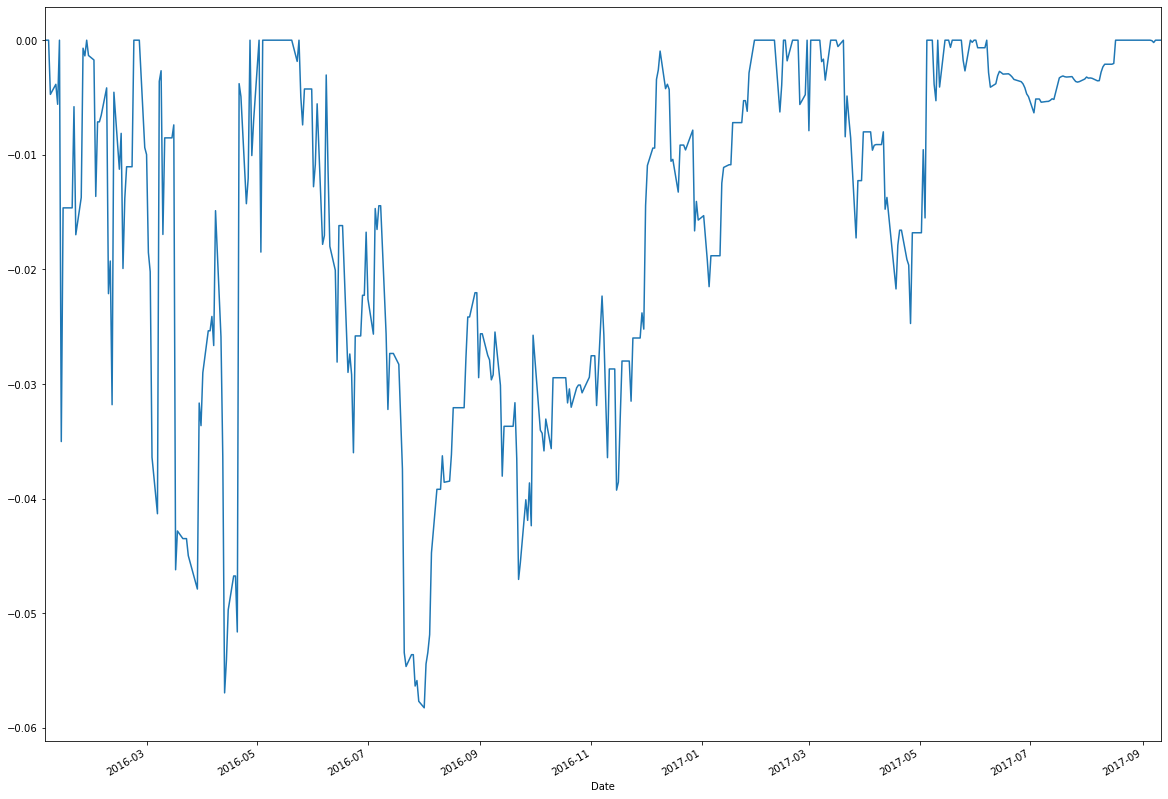

In [33]:
drawdown.plot(figsize=(20,15))
maxdd, maxdd_period

In [34]:
final_res.values

array([1.        , 1.        , 1.        , 0.99527254, 0.99614998,
       0.99440772, 1.00129072, 0.96623644, 0.98664561, 0.98664561,
       0.98664561, 0.98664561, 0.99548315, 0.98429962, 0.98755381,
       1.00059007, 0.99991841, 1.01344009, 1.01208708, 1.01169118,
       0.9996297 , 1.0062197 , 1.0062197 , 1.00679509, 1.00922365,
       0.99103415, 0.99391933, 0.9812183 , 1.00883809, 1.00203293,
       1.00520387, 0.99325905, 0.99944658, 1.00225201, 1.00225201,
       1.01717499, 1.01717499, 1.01850853, 1.02980686, 1.02015941,
       1.01953273, 1.01073598, 1.00900916, 0.99234524, 0.98727158,
       1.02610646, 1.02706246, 1.01235663, 1.02103217, 1.02103217,
       1.02103217, 1.02219877, 0.98223803, 0.98572387, 0.98503691,
       0.98503691, 0.98503691, 0.98350189, 0.98050772, 0.99721388,
       0.99518477, 0.99993744, 1.00370289, 1.00370289, 1.00499132,
       1.00237857, 1.01449248, 1.0031688 , 0.99242088, 0.9711799 ,
       0.97408723, 0.97864173, 0.98168017, 0.98168017, 0.97665